In [ ]:
!pip install transformers -q
!pip install --upgrade ai2thor --quiet
!pip install ai2thor-colab prior --upgrade &> /dev/null

In [ ]:
import warnings,logging
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)
import time
import random
import os
import numpy as np
import pandas as pd
import prior

from statistics import mode

os.system('apt-get update')
os.system('apt-get install xvfb')

import ai2thor_colab
from ai2thor.controller import Controller
from ai2thor.platform import CloudRendering
from PIL import Image

from transformers import pipeline
from transformers import BertTokenizer, BertModel

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import torch

In [ ]:
# Image to caption model
captioner = pipeline(model="ydshieh/vit-gpt2-coco-en")
caption = pipeline('image-to-text')
def image_to_caption(img):
    image_text= caption(img)[0]
    return image_text

def encode_text_with_bert(text):
    # Load pre-trained BERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    # Tokenize the text
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Convert input IDs to PyTorch tensor
    input_ids = torch.tensor(input_ids).unsqueeze(0)

    # Get BERT embeddings for the input text
    with torch.no_grad():
        outputs = model(input_ids)
         # Use mean pooling to get a fixed-size embedding vector
        bert_embeddings = outputs.last_hidden_state.mean(dim=1)

    return bert_embeddings

In [ ]:
# Robot movement and decisions

def right_side(rotate=False):
    if not rotate:
        frame_right = controller.step("RotateRight", degrees=90).frame
        controller.step("RotateLeft", degrees=90)
    else:
        frame_right = controller.step("RotateRight", degrees=90).frame
    return Image.fromarray(frame_right)


def front_right_side(rotate=False):
    if not rotate:
        frame_right = controller.step("RotateRight", degrees=45).frame
        controller.step("RotateLeft", degrees=45)
    else:
        frame_right = controller.step("RotateRight", degrees=45).frame
    return Image.fromarray(frame_right)

def left_side(rotate=False):
    if not rotate:
        frame_left = controller.step("RotateLeft", degrees=90).frame
        controller.step("RotateRight", degrees=90)
    else:
        frame_left = controller.step("RotateLeft", degrees=90).frame
    return Image.fromarray(frame_left)

def front_left_side(rotate=False):
    if not rotate:
        frame_left = controller.step("RotateLeft", degrees=45).frame
        controller.step("RotateRight", degrees=45)
    else:
        frame_left = controller.step("RotateLeft", degrees=45).frame
    return Image.fromarray(frame_left)

def back_side(rotate=False):
    if not rotate:
        frame_back = controller.step("RotateLeft", degrees=180).frame
        controller.step("RotateRight", degrees=180)
    else:
        frame_back = controller.step("RotateLeft", degrees=180).frame
    return Image.fromarray(frame_back)

def back_left_side(rotate=False):
    if not rotate:
        frame_back = controller.step("RotateLeft", degrees=135).frame
        controller.step("RotateRight", degrees=135)
    else:
        frame_back = controller.step("RotateLeft", degrees=135).frame
    return Image.fromarray(frame_back)

def back_right_side(rotate=False):
    if not rotate:
        frame_back = controller.step("RotateRight", degrees=135).frame
        controller.step("RotateLeft", degrees=135)
    else:
        frame_back = controller.step("RotateRight", degrees=135).frame
    return Image.fromarray(frame_back)

sm_s=[]
def front_side(action=None,move=False, similarity_score=None):
    global sm_s
    if move:
        sm_s.append(similarity_score)
        sm_s = sm_s[-2:]
        # To check the robot stays in the same position (bump into an object)
        if sum(sm_s)/2!= similarity_score:
            controller.step("MoveAhead")
            actions[time.perf_counter()]=(f'MoveAhead')
        else:
            move_to_closest_point(action)
            actions[time.perf_counter()]=(f'move_to_closest_point')
            sm_s=[]
    frame_front = controller.last_event.frame
    return Image.fromarray(frame_front)

def move_to_closest_point(direction):
    current_rotation = controller.last_event.metadata['agent']['rotation']['y']
    current_position = controller.last_event.metadata['agent']['position']
    reachable_positions = controller.step(action="GetReachablePositions").metadata["actionReturn"]
    front_points, back_points, right_points, left_points = extract_directional_points(current_position, reachable_positions)
    event = controller.step(action="Teleport", position=right_points[0])


def extract_directional_points(current_position, reachable_positions):
    # Calculate Euclidean distance for each point from the current position
    distances = [
        np.linalg.norm(np.array([pos['x'], pos['z']]) - np.array([current_position['x'], current_position['z']]))
        for pos in reachable_positions
    ]
    # Combine reachable positions with their distances
    positions_with_distance = zip(reachable_positions, distances)

    # Sort the positions based on the distances
    sorted_positions = sorted(positions_with_distance, key=lambda x: x[1])

    # Extract sorted reachable positions
    sorted_reachable_positions = [pos[0] for pos in sorted_positions]

    # Function to project points along a direction
    def project_points(direction_vector):
        projected_points = []
        for pos in sorted_reachable_positions:
            relative_position = np.array([pos['x'], pos['z']]) - np.array([current_position['x'], current_position['z']])
            projection = np.dot(relative_position, direction_vector)
            if projection > 0:
                projected_points.append(pos)
        return projected_points

    # Direction vectors
    front_vector = np.array([0, -1])
    right_vector = np.array([1, 0])
    back_vector = np.array([0, 1])
    left_vector = np.array([-1, 0])

    # Extract points in each direction
    front_points = project_points(front_vector)
    right_points = project_points(right_vector)
    back_points = project_points(back_vector)
    left_points = project_points(left_vector)

    return front_points, right_points, back_points, left_points

def teleport_randomly():
    event = controller.step(action="GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    position = random.choice(reachable_positions)
    # rotation = random.choice(range(360))
    controller.step(action="Teleport", position=position)



def low_score_actions(action, similarity_score):
    if action == "front_side":
        front_side(action=action,move=True,similarity_score=similarity_score)
    else:
        temp= 'rotate '+ action
        actions[time.perf_counter()]=temp
        if action == "right_side":
            right_side(rotate=True)
        elif action == "left_side":
            left_side(rotate=True)
        elif action == "back_side":
            back_side(rotate=True)
        elif action == "front_right_side":
            front_right_side(rotate=True)
        elif action == "front_left_side":
            front_left_side(rotate=True)
        elif action == "back_left_side":
            back_left_side(rotate=True)
        elif action == "back_right_side":
            back_right_side(rotate=True)

In [ ]:
# Save all actions and movements
def save_to_txt(file_path):
    with open(file_path, 'w') as file:
        for key, value in actions.items():
            file.write(f"{key}: {value}\n")

In [ ]:
def train_model_and_vectorizer(data, text_column, class_column):
    # Split the dataset into training and testing sets
    X = data[text_column]
    y = data[class_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Vectorize the text data using CountVectorizer
    vectorizer = CountVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Initialize and train a logistic regression model
    model = LogisticRegression(max_iter=1000)  
    model.fit(X_train_vec, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_vec)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'Classification Report:\n{classification_rep}')

    # Return the trained model and vectorizer
    return model, vectorizer

# The training data that we built
url = 'https://raw.githubusercontent.com/Mohammed-majeed/Communicative-Robots/main/processed_room_classification_data.csv'
data = pd.read_csv(url)

# Column names for text and class labels
text_column_name = 'text'
class_column_name = 'labels'

# Train the model and get the trained model and vectorizer
trained_model, trained_vectorizer = train_model_and_vectorizer(data, text_column_name, class_column_name)

def predict_room(text):
    X_test_vec = trained_vectorizer.transform([text])
    predicted_labels = trained_model.predict(X_test_vec)

    return predicted_labels[0]

Accuracy: 0.8651685393258427
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       1.00      0.75      0.86        20
           2       1.00      0.80      0.89        15
           3       0.81      1.00      0.90        43

    accuracy                           0.87        89
   macro avg       0.90      0.80      0.84        89
weighted avg       0.88      0.87      0.86        89



In [ ]:
# Get views of the room and their captions
def images_to_room():

    # Define side views
    side_views = {
    "front_side":front_side,
    "right_side": right_side,
    "left_side": left_side,
    "back_side": back_side,
    # "front_right_side": front_right_side,
    # "front_left_side": front_left_side,
    # "back_left_side": back_left_side,
    # "back_right_side": back_right_side
    }

    view_room_predictions = []
    images = {}
    for view_name, func in side_views.items():
        actions[time.perf_counter()]=f'{view_name} View'
        image = func()
        generated_caption = image_to_caption(image)['generated_text']
        view_room_predictions.append(predict_room(generated_caption))
        images[view_name] = (generated_caption, predict_room(generated_caption), image)

    robot_room_prediction = mode(view_room_predictions)
    return robot_room_prediction, images

# Check similarity between input text and captions
def check_similarity(input_text, captions):
    input_text_embeddings = encode_text_with_bert(input_text)
    similarity_score = {}
    for view_name, (caption_text, _, image) in captions.items():
        robot_text_embeddings = encode_text_with_bert(caption_text)
        cosine_sim = cosine_similarity(input_text_embeddings, robot_text_embeddings)[0][0]
        similarity_score[view_name] = {'cosine_similarity': cosine_sim, 'caption': caption_text, 'image': image}
    highest_view = max(similarity_score, key=lambda key: similarity_score[key]['cosine_similarity'])

    return highest_view, similarity_score[highest_view]

In [ ]:
# To find the object in the scene
def find_object(target_name,caption):
    target= target_name.replace(" ","")
    for object in controller.last_event.metadata["objects"]:
        if object["visible"] and target.lower() in object["name"].lower():
            # frame_front = controller.last_event.frame
            # display(Image.fromarray(frame_front))
            print(f'I see {caption}')
            user = input('Please enter (Yes or No): ')
            if user.lower() == 'yes':
                print(f"The object ID {object['visible']}")
                actions[time.perf_counter()]="Yes, I found the object"
                actions[time.perf_counter()]=object["visible"]
                return True
            else:
                actions[time.perf_counter()]="No, I will continue looking for the object"
                print('I will continue looking for the object')
                teleport_randomly()
                actions[time.perf_counter()]="Teleport_randomly: It is not the same object"


In [ ]:
# Main processing function
def process_scene(input_text,target_name):
    input_room_prediction = predict_room(input_text)
    for iteration in range(MAX_ITERATIONS):
        actions[time.perf_counter()]=f"{str(iteration)}"
        robot_room_prediction, images = images_to_room()
        if robot_room_prediction == input_room_prediction:
            actions[time.perf_counter()]= f"Same Room"
            similarity_view, highest_details = check_similarity(input_text, images)
            similarity_score = highest_details['cosine_similarity']
            if similarity_score >= COSINE_SIMILARITY_THRESHOLD:
                actions[time.perf_counter()]=f'Place Found'
                if find_object(target_name, highest_details['caption'] ):
                    actions[time.perf_counter()]=f'object Found'
                    break

                actions[time.perf_counter()]= "I found a different object"
                low_score_actions(similarity_view, similarity_score)

            elif CLOSE_OBJECTS_THRESHOLD_LOW <= similarity_score < CLOSE_OBJECTS_THRESHOLD_HIGH:
                actions[time.perf_counter()]= "close to the scene"
                low_score_actions(similarity_view, similarity_score)
            else:
                teleport_randomly()
                actions[time.perf_counter()]="Teleport_randomly: similarity score below threshold"
        else:
            teleport_randomly()
            actions[time.perf_counter()]= "Teleport_randomly: Not in the same room"
        if iteration % 10==0:
          print("I'm searching")

In [ ]:
# Import the house

dataset = prior.load_dataset("procthor-10k")
#house = dataset["train"][11]

dataset["train"][5808]["objects"][9]["children"][2] = {
  'assetId': 'Laptop_13',
  'id': "Laptop|surface|10|71",
  'kinematic': False,
  'openness': 0,
  'position': {'x': 5.308516502380371,
  'y': 0.960530161857605,
  'z': 3.317396640777588},
  'rotation': {'x': -0.0, 'y': 0.0, 'z': 0.0},
  'layer': 'Procedural1'}

new_house = dataset["train"][5808]

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 7369.50it/s]


please describe what objects you saw : bedroom with a bed and yellow sheet and black blanket and a laptop
what object are you looking for? : laptop
I'm searching


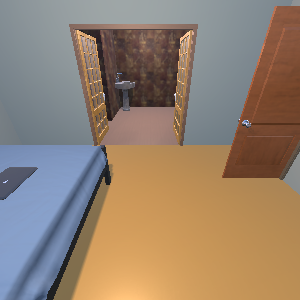

I see a bed with a blue blanket and a blue wall 
Please enter (Yes or No): no
I will continue looking for the object
I'm searching
I'm searching


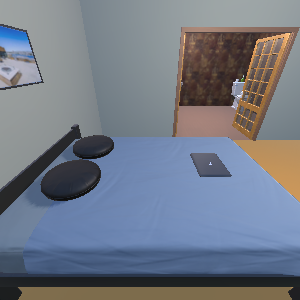

I see a bed with a blue blanket and a blue pillow 
Please enter (Yes or No): no
I will continue looking for the object
I'm searching
I'm searching
Search is done


In [ ]:
# For testing
actions = {}
COSINE_SIMILARITY_THRESHOLD = 0.85
CLOSE_OBJECTS_THRESHOLD_LOW = 0.80
CLOSE_OBJECTS_THRESHOLD_HIGH = 0.85
MAX_ITERATIONS = 50


ai2thor_colab.start_xserver()
controller = Controller(scene=new_house)
controller.reset(scene=new_house)
controller.step(action="AdvancePhysicsStep",timeStep=0.05)

# frame_front = controller.last_event.frame
# display(Image.fromarray(frame_front))

# e.g. bedroom with a bed and yellow sheet and black blanket and a laptop
image_description= input("please describe what objects you saw : ")
# e.g. laptop
target =input("what object are you looking for? : ")

process_scene(image_description,target)
print("Search is done")
# Save the actions and interactions
save_to_txt("saved_actions.txt")

In [ ]:
# Specify the path of the save action
file_path = 'saved_actions.txt'

# Open the file
with open(file_path, 'r') as file:
    # Load the data
    data = file.readlines()

data

['2193.512678543: 0\n',
 '2193.512684623: front_side View\n',
 '2196.650457004: right_side View\n',
 '2200.905501814: left_side View\n',
 '2204.246856619: back_side View\n',
 '2207.491448141: Teleport_randomly: Not in the same room\n',
 '2207.491548372: 1\n',
 '2207.491554901: front_side View\n',
 '2209.202172251: right_side View\n',
 '2211.549979987: left_side View\n',
 '2213.534276124: back_side View\n',
 '2215.579294155: Same Room\n',
 '2229.172659409: close to the scene\n',
 '2229.88668707: MoveAhead\n',
 '2229.892276559: 2\n',
 '2229.89228445: front_side View\n',
 '2231.58727091: right_side View\n',
 '2233.860391623: left_side View\n',
 '2235.973765809: back_side View\n',
 '2238.432563886: Teleport_randomly: Not in the same room\n',
 '2238.432568436: 3\n',
 '2238.432573296: front_side View\n',
 '2240.143938045: right_side View\n',
 '2243.232789411: left_side View\n',
 '2245.989890534: back_side View\n',
 '2248.444916361: Teleport_randomly: Not in the same room\n',
 '2248.444920152